In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## Review: Comparing Two Samples

In [2]:
def difference_of_means(table, numeric_label, group_label):
    """
    Takes: name of table, column label of numerical variable,
    column label of group-label variable
    
    Returns: Difference of means of the two groups
    """
    
    #table with the two relevant columns
    reduced = table.select(numeric_label, group_label)  
    
    # table containing group means
    means_table = reduced.group(group_label, np.average)
    
    # array of group means
    means = means_table.column(1)
    
    return means.item(1) - means.item(0)

In [3]:
def one_simulated_difference(table, numeric_label, group_label):
    """
    Takes: name of table, column label of numerical variable,
    column label of group-label variable
    
    Returns: Difference of means of the two groups after shuffling labels
    """
    
    # array of shuffled labels
    shuffled_labels = table.sample(with_replacement = False).column(group_label)
    
    # table of numerical variable and shuffled labels
    shuffled_table = table.select(numeric_label).with_column('Shuffled Label', shuffled_labels)
    
    return difference_of_means(shuffled_table, numeric_label, 'Shuffled Label')   

In [4]:
births = Table.read_table('data/baby.csv')

In [5]:
births.group('Maternal Smoker', np.average)

Maternal Smoker,Birth Weight average,Gestational Days average,Maternal Age average,Maternal Height average,Maternal Pregnancy Weight average
False,123.085,279.874,27.5441,64.014,129.48
True,113.819,277.898,26.7364,64.1046,126.919


# Randomized Control Experiment

In [49]:
botox = Table.read_table('data/bta.csv')
botox.show()

Group,Result
Control,1
Control,1
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0


# Task:
- Summarize the dataset: show the unique combinations
    - How many people got treatment and experienced improvements?
    - How many people got placebo and experienced improvements?
    - How many people got treatment and didnt experienced improvements?
    - How many people got placebo and didnt experienced improvements?
- Calculate the share of improvements per group

In [ ]:
botox.pivot('Result', 'Group')

Group,0.0,1.0
Control,14,2
Treatment,6,9


In [ ]:
botox.group('Group', np.average)

Group,Result average
Control,0.125
Treatment,0.6


## Tickets
is the distribution of the 

- 31 “treatment” values in Column 1 (including the unknown ones) 
different from the distribution of the 
- 31 “control” values in Column 2 (again including the unknown ones)?

In [39]:
botox = botox.with_column('Outcome if assigned treatment', botox.column('Result'))
botox.column('Outcome if assigned treatment')[botox.column('Group') != 'Treatment'] = np.nan

botox = botox.with_column('Outcome if assigned control', botox.column('Result'))
botox.column('Outcome if assigned control')[botox.column('Group') != 'Control'] = np.nan

botox.show()

Group,Result,Outcome if assigned treatment,Outcome if assigned control
Control,1,nan,1
Control,1,nan,1
Control,0,nan,0
Control,0,nan,0
Control,0,nan,0
Control,0,nan,0
Control,0,nan,0
Control,0,nan,0
Control,0,nan,0
Control,0,nan,0


# Testing the Hypothesis

In [40]:
observed_diff = difference_of_means(botox, 'Result', 'Group')
observed_diff

0.475

In [41]:
one_simulated_difference(botox, 'Result', 'Group')

0.21666666666666667

# Task: 
1. Simulate the difference 10k times
1. Create a table containing the simulations
1. Plot the histogram
    - Question: in which direction is the alternative?
    - Where on the histogram is the *observed* difference?
    - Bonus: Add the observed difference as a dot into the histogram (use `plots.scatter()`).
1. Calculate the p-value ([hint](https://inferentialthinking.com/chapters/12/1/AB_Testing.html#conclusion-of-the-test))
1. Choose a p-value cutoff

In [42]:
simulated_diffs = make_array()

for i in np.arange(10000):
    sim_diff = one_simulated_difference(botox, 'Result', 'Group')
    simulated_diffs = np.append(simulated_diffs, sim_diff)

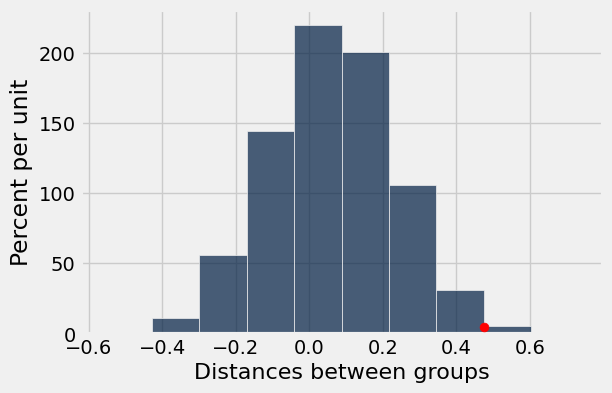

In [60]:
col_name = 'Distances between groups'
Table().with_column(col_name, simulated_diffs).hist(col_name)
plots.scatter(observed_diff, 0.05, color='red', s=40, zorder=3)

In [45]:
# p-value
sum(simulated_diffs >= observed_diff) / len(simulated_diffs)

0.0074000000000000003